In [1]:
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Reading data
df = pd.read_csv('./data/cycle-counts-1-jan-2-april-2023.csv')

# Convert the 'Time' to pandas datetime format
df['Time'] = pd.to_datetime(df['Time'], dayfirst=True)
# Separating the date and the hours
df["Date"] = df["Time"].dt.date
df["Time"] = df["Time"].dt.time

# Dropping the unncesessary columns
for column in df:
    if "IN" in column:
        df.drop(column, axis=1, inplace=True)
    elif "OUT" in column:
        df.drop(column, axis=1, inplace=True)
    elif "North Strand" in column:
        df.drop(column, axis=1, inplace=True)
    elif "Drumcondra Cyclists 1" in column:
        df.drop(column, axis=1, inplace=True)

# Setting the 'Date' as the index
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
# Resampling the dataset to show only days and not hours
df = df.resample("D").sum()
# Creating a 'Time' column that shows the steps for predicting
df['Time'] = np.arange(len(df.index))

print(df)

            Charleville Mall  Clontarf - James Larkin Rd  \
Date                                                       
2023-01-01                73                         448   
2023-01-02               121                        1074   
2023-01-03               245                         374   
2023-01-04               298                         478   
2023-01-05               342                         542   
...                      ...                         ...   
2023-03-29               540                         628   
2023-03-30               506                         963   
2023-03-31               326                         409   
2023-04-01               135                         413   
2023-04-02               170                        1610   

            Clontarf - Pebble Beach Carpark  Drumcondra Cyclists 2  \
Date                                                                 
2023-01-01                              604                     38   
2023-01-0

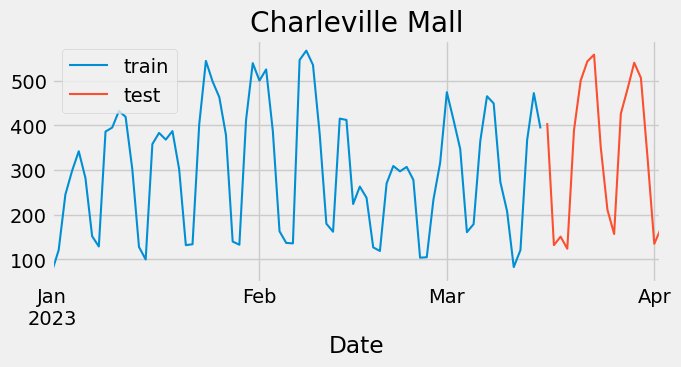

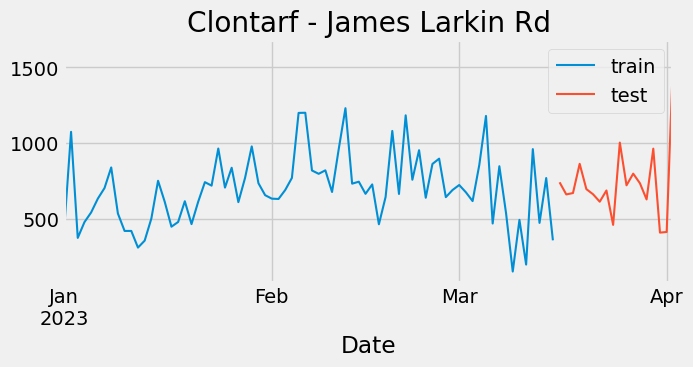

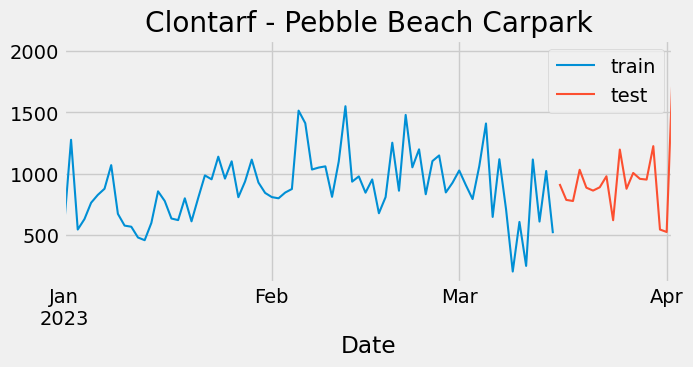

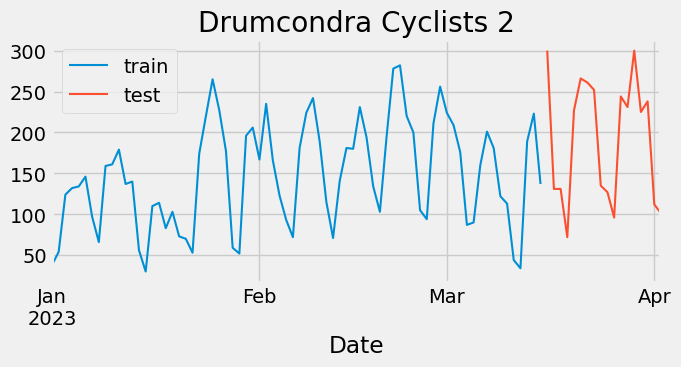

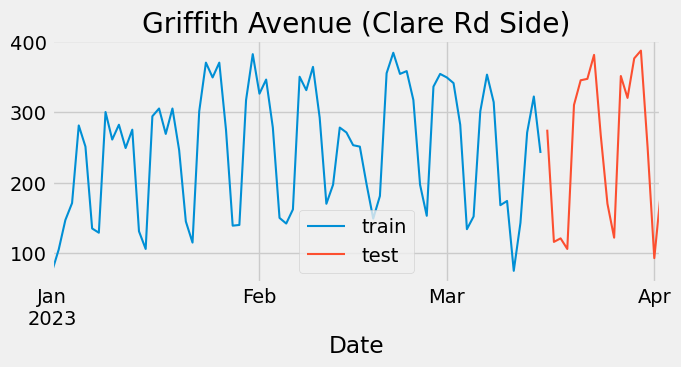

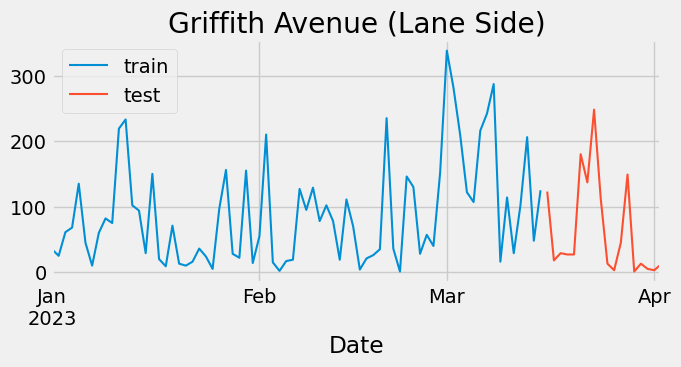

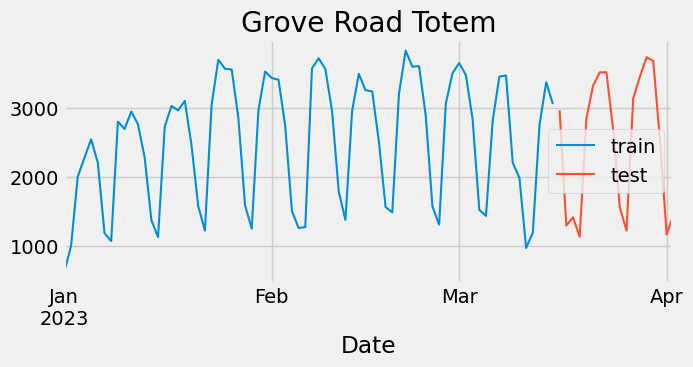

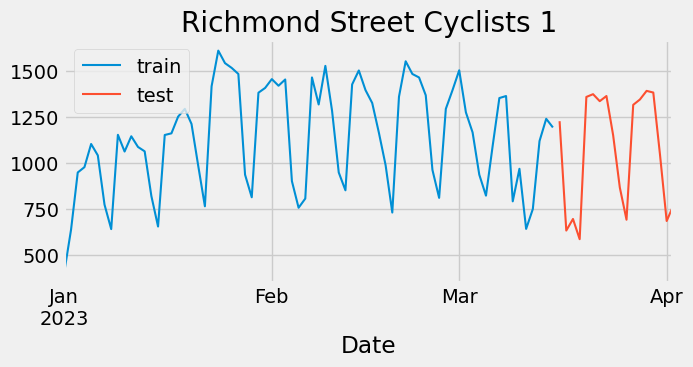

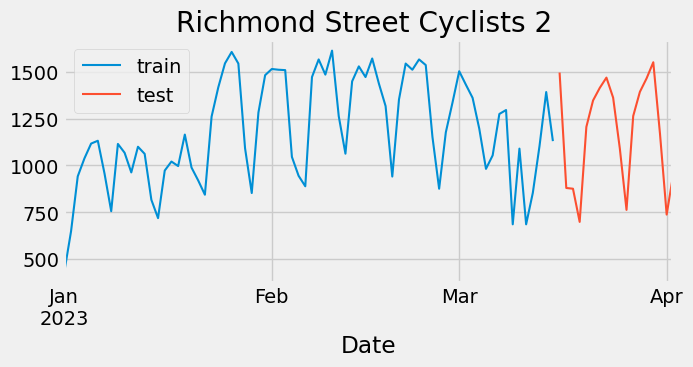

In [2]:
# Split data into train-test
# ==============================================================================
steps = 18
data_train = df[:-steps]
data_test  = df[-steps:]
# print(df.iloc[:-steps])
# print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
# print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotting the train data and the test data for 'Charleville Mall'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Charleville Mall'].plot(ax=ax, label='train')
data_test['Charleville Mall'].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Charleville Mall');

# Plotting the train data and the test data for 'Clontarf - James Larkin Rd'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Clontarf - James Larkin Rd'].plot(ax=ax, label='train')
data_test['Clontarf - James Larkin Rd'].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Clontarf - James Larkin Rd');

# Plotting the train data and the test data for 'Clontarf - Pebble Beach Carpark'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Clontarf - Pebble Beach Carpark'].plot(ax=ax, label='train')
data_test['Clontarf - Pebble Beach Carpark'].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Clontarf - Pebble Beach Carpark');

# Plotting the train data and the test data for 'Drumcondra Cyclists 2'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Drumcondra Cyclists 2'].plot(ax=ax, label='train')
data_test['Drumcondra Cyclists 2'].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Drumcondra Cyclists 2');

# Plotting the train data and the test data for 'Griffith Avenue (Clare Rd Side)'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Griffith Avenue (Clare Rd Side)'].plot(ax=ax, label='train')
data_test['Griffith Avenue (Clare Rd Side)'].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Griffith Avenue (Clare Rd Side)');

# Plotting the train data and the test data for 'Griffith Avenue (Lane Side)'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Griffith Avenue (Lane Side)'].plot(ax=ax, label='train')
data_test['Griffith Avenue (Lane Side)'].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Griffith Avenue (Lane Side)');

# Plotting the train data and the test data for 'Grove Road Totem'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Grove Road Totem'].plot(ax=ax, label='train')
data_test['Grove Road Totem'].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Grove Road Totem');

# Plotting the train data and the test data for 'Richmond Street Cyclists 1'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Richmond Street Cyclists 1'].plot(ax=ax, label='train')
data_test['Richmond Street Cyclists 1'].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Richmond Street Cyclists 1');

# Plotting the train data and the test data for 'Richmond Street Cyclists 2'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Richmond Street Cyclists 2 '].plot(ax=ax, label='train')
data_test['Richmond Street Cyclists 2 '].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Richmond Street Cyclists 2 ');

In [3]:
# Create and train forecaster
# ==============================================================================

# Forecaster for 'Charleville Mall'
regressor_charleville = RandomForestRegressor(random_state=123)
forecaster_charleville = ForecasterAutoreg(
                regressor = regressor_charleville,
                lags      = 6
             )

forecaster_charleville.fit(y=data_train['Charleville Mall'])


# Forecaster for 'Clontarf - James Larkin Rd'
regressor_clontarf_james = RandomForestRegressor(random_state=123)
forecaster_clontarf_james = ForecasterAutoreg(
                regressor = regressor_clontarf_james,
                lags      = 6
             )

forecaster_clontarf_james.fit(y=data_train['Clontarf - James Larkin Rd'])


# Forecaster for 'Clontarf - Pebble Beach Carpark'
regressor_clontarf_pebble = RandomForestRegressor(random_state=123)
forecaster_clontarf_pebble = ForecasterAutoreg(
                regressor = regressor_clontarf_pebble,
                lags      = 6
             )

forecaster_clontarf_pebble.fit(y=data_train['Clontarf - Pebble Beach Carpark'])


# Forecaster for 'Drumcondra Cyclists 2'
regressor_drumcondra = RandomForestRegressor(random_state=123)
forecaster_drumcondra = ForecasterAutoreg(
                regressor = regressor_drumcondra,
                lags      = 6
             )

forecaster_drumcondra.fit(y=data_train['Drumcondra Cyclists 2'])


# Forecaster for 'Griffith Avenue (Clare Rd Side)'
regressor_griffith_clare = RandomForestRegressor(random_state=123)
forecaster_griffith_clare = ForecasterAutoreg(
                regressor = regressor_griffith_clare,
                lags      = 6
             )

forecaster_griffith_clare.fit(y=data_train['Griffith Avenue (Clare Rd Side)'])


# Forecaster for 'Griffith Avenue (Lane Side)'
regressor_griffith_lane = RandomForestRegressor(random_state=123)
forecaster_griffith_lane = ForecasterAutoreg(
                regressor = regressor_griffith_lane,
                lags      = 6
             )

forecaster_griffith_lane.fit(y=data_train['Griffith Avenue (Lane Side)'])


# Forecaster for 'Grove Road Totem'
regressor_grove = RandomForestRegressor(random_state=123)
forecaster_grove = ForecasterAutoreg(
                regressor = regressor_grove,
                lags      = 6
             )

forecaster_grove.fit(y=data_train['Grove Road Totem'])


# Forecaster for 'Richmond Street Cyclists 1'
regressor_richmond_1 = RandomForestRegressor(random_state=123)
forecaster_richmond_1 = ForecasterAutoreg(
                regressor = regressor_richmond_1,
                lags      = 6
             )

forecaster_richmond_1.fit(y=data_train['Richmond Street Cyclists 1'])


# Forecaster for 'Richmond Street Cyclists 2'
regressor_richmond_2 = RandomForestRegressor(random_state=123)
forecaster_richmond_2 = ForecasterAutoreg(
                regressor = regressor_richmond_2,
                lags      = 6
             )

forecaster_richmond_2.fit(y=data_train['Richmond Street Cyclists 2 '])

In [4]:
# Predictions
# ==============================================================================
# 18 steps is to predict the test data

# Predictions for 'Charleville Mall'
predictions_charleville = forecaster_charleville.predict(steps=18)

# Predictions for 'Clontarf - James Larkin Rd'
predictions_clontarf_james = forecaster_clontarf_james.predict(steps=18)

# Predictions for 'Clontarf - Pebble Beach Carpark'
predictions_clontarf_pebble = forecaster_clontarf_pebble.predict(steps=18)

# Predictions for 'Drumcondra Cyclists 2'
predictions_drumcondra = forecaster_drumcondra.predict(steps=18)

# Predictions for 'Griffith Avenue (Clare Rd Side)'
predictions_griffith_clare = forecaster_griffith_clare.predict(steps=18)

# Predictions for 'Griffith Avenue (Lane Side)'
predictions_griffith_lane = forecaster_griffith_lane.predict(steps=18)

# Predictions for 'Grove Road Totem'
predictions_grove = forecaster_grove.predict(steps=18)

# Predictions for 'Richmond Street Cyclists 1'
predictions_richmond_1 = forecaster_richmond_1.predict(steps=18)

# Predictions for 'Richmond Street Cyclists 2'
predictions_richmond_2 = forecaster_richmond_2.predict(steps=18)

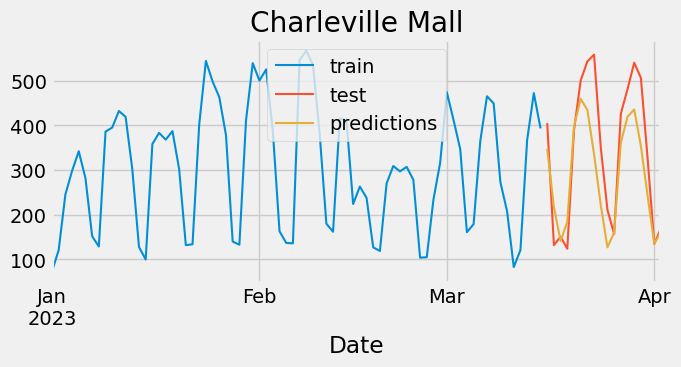

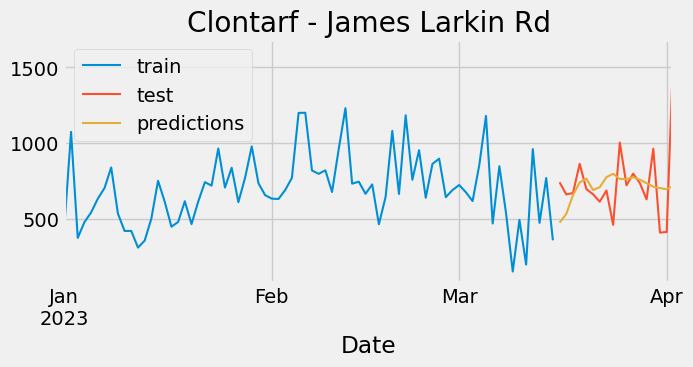

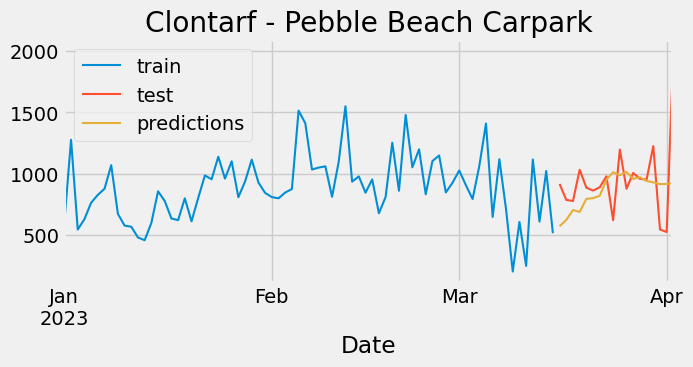

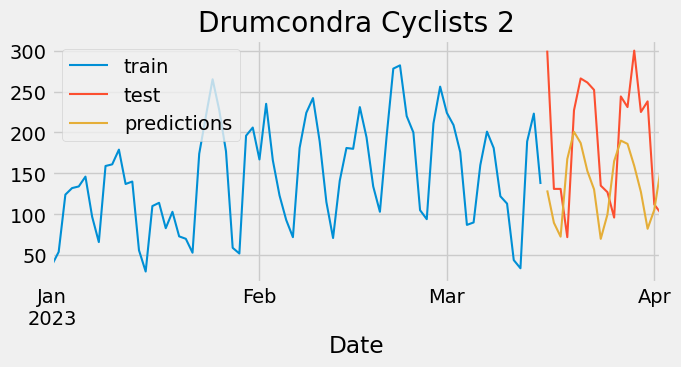

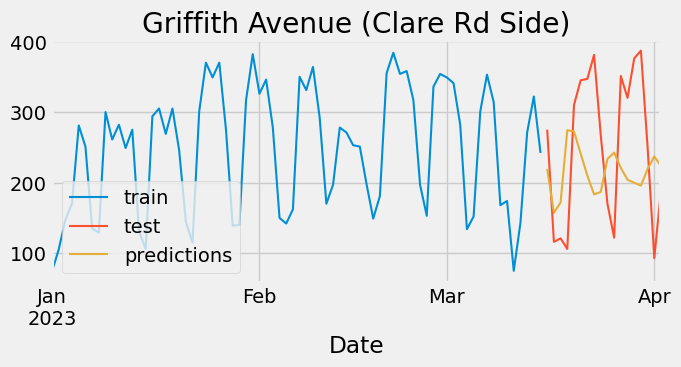

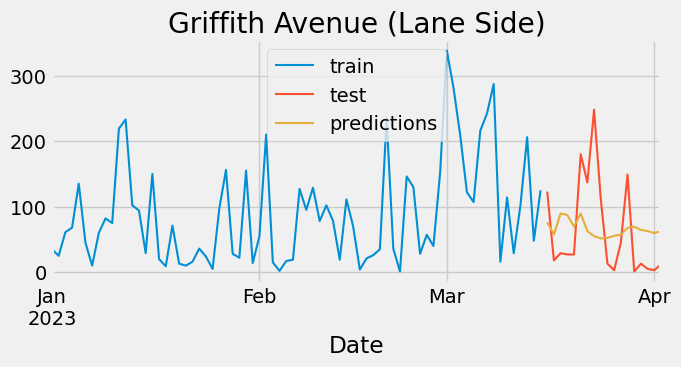

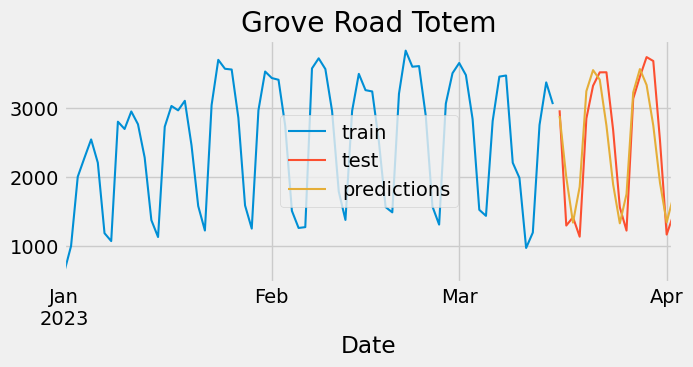

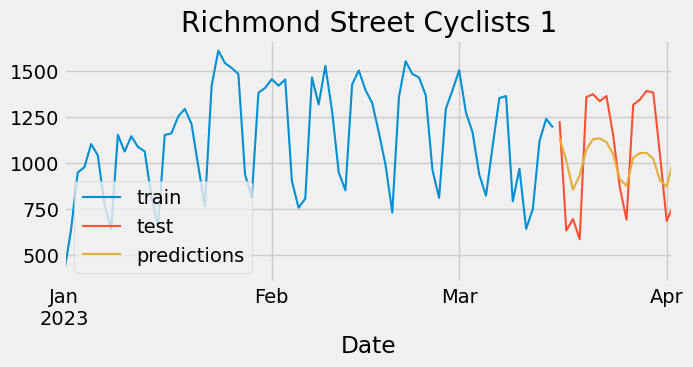

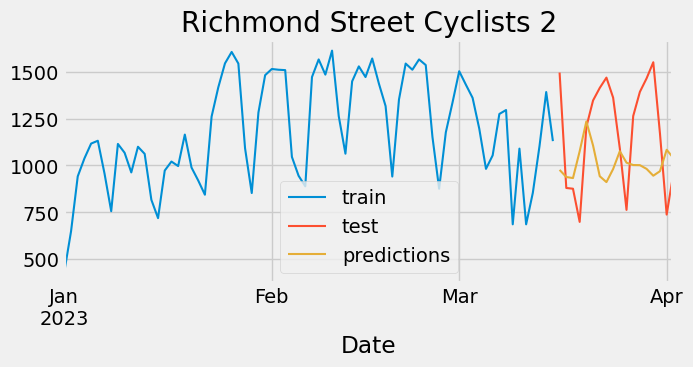

In [5]:
# Plotting the test, train, and prediction data
# ==============================================================================

# 'Charleville Mall'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Charleville Mall'].plot(ax=ax, label='train')
data_test['Charleville Mall'].plot(ax=ax, label='test')
predictions_charleville.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Charleville Mall');

# 'Clontarf - James Larkin Rd'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Clontarf - James Larkin Rd'].plot(ax=ax, label='train')
data_test['Clontarf - James Larkin Rd'].plot(ax=ax, label='test')
predictions_clontarf_james.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Clontarf - James Larkin Rd');

# 'Clontarf - Pebble Beach Carpark'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Clontarf - Pebble Beach Carpark'].plot(ax=ax, label='train')
data_test['Clontarf - Pebble Beach Carpark'].plot(ax=ax, label='test')
predictions_clontarf_pebble.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Clontarf - Pebble Beach Carpark');

# 'Drumcondra Cyclists 2'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Drumcondra Cyclists 2'].plot(ax=ax, label='train')
data_test['Drumcondra Cyclists 2'].plot(ax=ax, label='test')
predictions_drumcondra.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Drumcondra Cyclists 2');

# 'Griffith Avenue (Clare Rd Side)'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Griffith Avenue (Clare Rd Side)'].plot(ax=ax, label='train')
data_test['Griffith Avenue (Clare Rd Side)'].plot(ax=ax, label='test')
predictions_griffith_clare.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Griffith Avenue (Clare Rd Side)');

# 'Griffith Avenue (Lane Side)'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Griffith Avenue (Lane Side)'].plot(ax=ax, label='train')
data_test['Griffith Avenue (Lane Side)'].plot(ax=ax, label='test')
predictions_griffith_lane.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Griffith Avenue (Lane Side)');

# 'Grove Road Totem'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Grove Road Totem'].plot(ax=ax, label='train')
data_test['Grove Road Totem'].plot(ax=ax, label='test')
predictions_grove.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Grove Road Totem');

# 'Richmond Street Cyclists 1'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Richmond Street Cyclists 1'].plot(ax=ax, label='train')
data_test['Richmond Street Cyclists 1'].plot(ax=ax, label='test')
predictions_richmond_1.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Richmond Street Cyclists 1');

# 'Richmond Street Cyclists 2'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Richmond Street Cyclists 2 '].plot(ax=ax, label='train')
data_test['Richmond Street Cyclists 2 '].plot(ax=ax, label='test')
predictions_richmond_2.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Richmond Street Cyclists 2');

In [6]:
# Predictions for the whole year
# ==============================================================================
# 291 steps is to predict the whole year

# Predictions for 'Charleville Mall'
predictions_charleville = forecaster_charleville.predict(steps=291)

# Predictions for 'Clontarf - James Larkin Rd'
predictions_clontarf_james = forecaster_clontarf_james.predict(steps=291)

# Predictions for 'Clontarf - Pebble Beach Carpark'
predictions_clontarf_pebble = forecaster_clontarf_pebble.predict(steps=291)

# Predictions for 'Drumcondra Cyclists 2'
predictions_drumcondra = forecaster_drumcondra.predict(steps=291)

# Predictions for 'Griffith Avenue (Clare Rd Side)'
predictions_griffith_clare = forecaster_griffith_clare.predict(steps=291)

# Predictions for 'Griffith Avenue (Lane Side)'
predictions_griffith_lane = forecaster_griffith_lane.predict(steps=291)

# Predictions for 'Grove Road Totem'
predictions_grove = forecaster_grove.predict(steps=291)

# Predictions for 'Richmond Street Cyclists 1'
predictions_richmond_1 = forecaster_richmond_1.predict(steps=291)

# Predictions for 'Richmond Street Cyclists 2'
predictions_richmond_2 = forecaster_richmond_2.predict(steps=18)

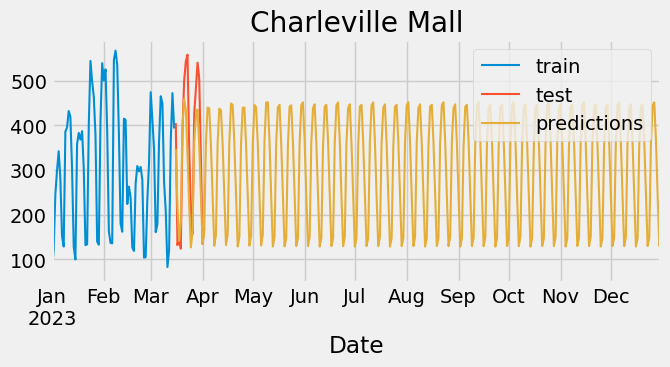

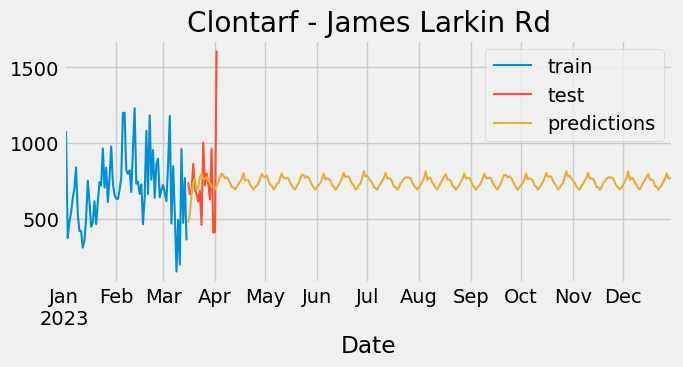

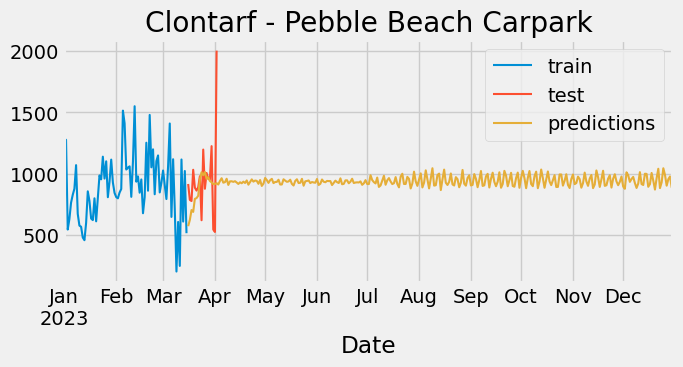

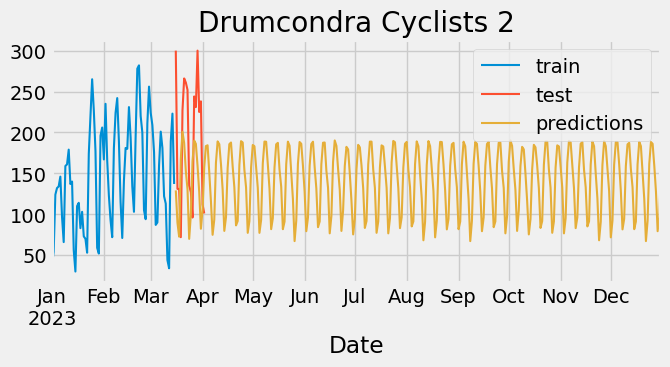

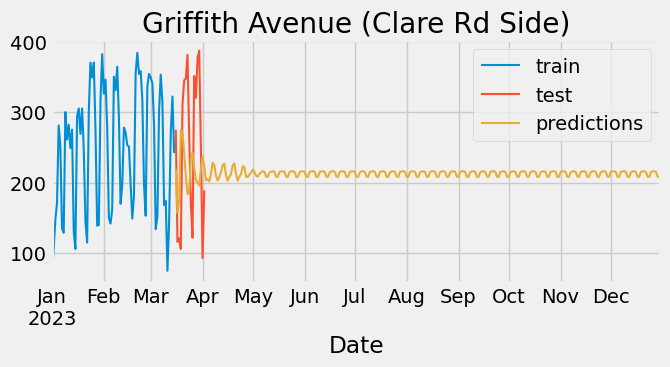

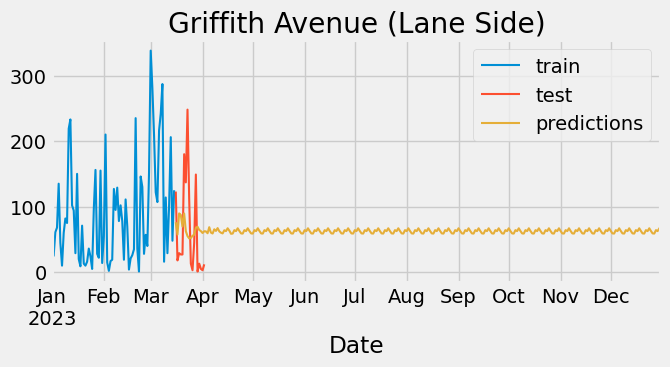

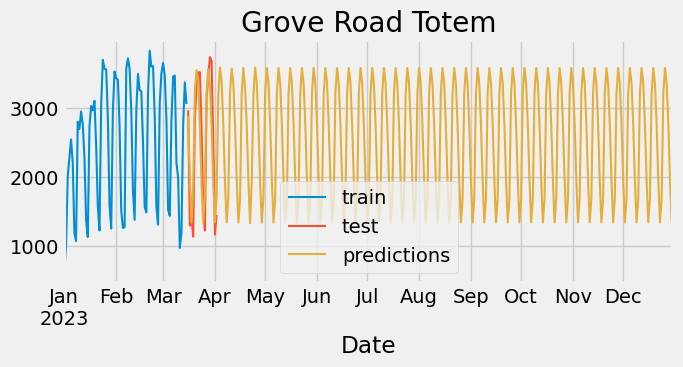

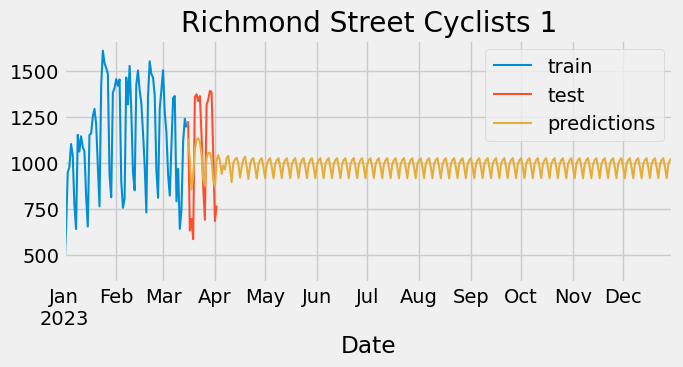

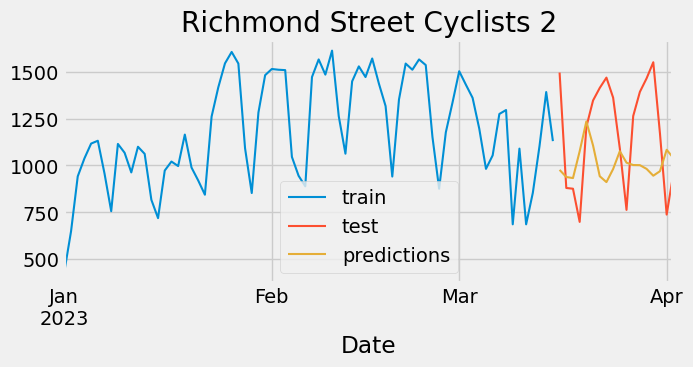

In [7]:
# Plotting the test, train, and prediction data for the whole year
# ==============================================================================

# 'Charleville Mall'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Charleville Mall'].plot(ax=ax, label='train')
data_test['Charleville Mall'].plot(ax=ax, label='test')
predictions_charleville.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Charleville Mall');

# 'Clontarf - James Larkin Rd'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Clontarf - James Larkin Rd'].plot(ax=ax, label='train')
data_test['Clontarf - James Larkin Rd'].plot(ax=ax, label='test')
predictions_clontarf_james.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Clontarf - James Larkin Rd');

# 'Clontarf - Pebble Beach Carpark'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Clontarf - Pebble Beach Carpark'].plot(ax=ax, label='train')
data_test['Clontarf - Pebble Beach Carpark'].plot(ax=ax, label='test')
predictions_clontarf_pebble.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Clontarf - Pebble Beach Carpark');

# 'Drumcondra Cyclists 2'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Drumcondra Cyclists 2'].plot(ax=ax, label='train')
data_test['Drumcondra Cyclists 2'].plot(ax=ax, label='test')
predictions_drumcondra.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Drumcondra Cyclists 2');

# 'Griffith Avenue (Clare Rd Side)'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Griffith Avenue (Clare Rd Side)'].plot(ax=ax, label='train')
data_test['Griffith Avenue (Clare Rd Side)'].plot(ax=ax, label='test')
predictions_griffith_clare.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Griffith Avenue (Clare Rd Side)');

# 'Griffith Avenue (Lane Side)'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Griffith Avenue (Lane Side)'].plot(ax=ax, label='train')
data_test['Griffith Avenue (Lane Side)'].plot(ax=ax, label='test')
predictions_griffith_lane.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Griffith Avenue (Lane Side)');

# 'Grove Road Totem'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Grove Road Totem'].plot(ax=ax, label='train')
data_test['Grove Road Totem'].plot(ax=ax, label='test')
predictions_grove.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Grove Road Totem');

# 'Richmond Street Cyclists 1'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Richmond Street Cyclists 1'].plot(ax=ax, label='train')
data_test['Richmond Street Cyclists 1'].plot(ax=ax, label='test')
predictions_richmond_1.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Richmond Street Cyclists 1');

# 'Richmond Street Cyclists 2'
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Richmond Street Cyclists 2 '].plot(ax=ax, label='train')
data_test['Richmond Street Cyclists 2 '].plot(ax=ax, label='test')
predictions_richmond_2.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Richmond Street Cyclists 2');

In [8]:
# Passing the data to a JSON file for the dashboard
df_charleville = predictions_charleville.reset_index()
df_charleville.rename(columns={"index": "Date"}, inplace=True)
df_clontarf_james = predictions_clontarf_james.reset_index()
df_clontarf_pebble = predictions_clontarf_pebble.reset_index()
df_drumcondra = predictions_drumcondra.reset_index()
df_griffith_clare = predictions_griffith_clare.reset_index()
df_griffith_lane = predictions_griffith_lane.reset_index()
df_grove = predictions_grove.reset_index()
df_richmond_1 = predictions_richmond_1.reset_index()
df_richmond_2 = predictions_richmond_2.reset_index()

predictions = {'Date': df_charleville['Date'],
               'Charleville Mall': df_charleville['pred'],
               'Clontarf - James Larkin Rd': df_clontarf_james['pred'],
               'Clontarf - Pebble Beach Carpark': df_clontarf_pebble['pred'],
               'Drumcondra Cyclists 2': df_drumcondra['pred'],
               'Griffith Avenue (Clare Rd Side)': df_griffith_clare['pred'],
               'Griffith Avenue (Lane Side)': df_griffith_lane['pred'],
               'Grove Road Totem': df_grove['pred'],
               'Richmond Street Cyclists 1': df_richmond_1['pred'],
               'Richmond Street Cyclists 2': df_richmond_2['pred'],
              }

df_2 = df.reset_index()
df_2.rename(columns={'Richmond Street Cyclists 2 ': 'Richmond Street Cyclists 2'}, inplace=True)
df_2.drop('Time', axis=1, inplace=True)
pred_df = pd.DataFrame(data=predictions)
predictions_df = pd.concat([df_2, pred_df], ignore_index=False)
predictions_df.iloc[:, 1:] = predictions_df.iloc[:, 1:].apply(np.ceil)
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'], dayfirst=True)
predictions_df.set_index('Date', inplace=True)
predictions_df.index = pd.to_datetime(predictions_df.index)
predictions_df = predictions_df.resample("W").sum()
predictions_df = predictions_df.reset_index()
predictions_df['Date'] = predictions_df['Date'].dt.strftime('%Y-%m-%d')
predictions_df.to_json('DA_Cycle.json', orient = "records", lines=True)

In [9]:
# Metric Evaluation
# Test  mean square error and r squared
# 'Charleville Mall'
predictions_charleville_test = forecaster_charleville.predict(steps=18)
mse_charleville_mall = mean_squared_error(
                y_true = data_test['Charleville Mall'],
                y_pred = predictions_charleville_test
            )

print(f"\nTest MSE Charleville Mall: {mse_charleville_mall}")

r2_charleville = r2_score(
                y_true = data_test['Charleville Mall'],
                y_pred = predictions_charleville_test
            )
print(f"Test R Squared Charleville Mall: {r2_charleville}")

# 'Clontarf - James Larkin Rd'
predictions_clontarf_james_test = forecaster_clontarf_james.predict(steps=18)
mse_clontarf_james = mean_squared_error(
                y_true = data_test['Clontarf - James Larkin Rd'],
                y_pred = predictions_clontarf_james_test
            )

print(f"\nTest MSE Clontarf - James Larkin Rd: {mse_clontarf_james}")

r2_clontarf_james = r2_score(
                y_true = data_test['Clontarf - James Larkin Rd'],
                y_pred = predictions_clontarf_james_test
            )
print(f"Test R Squared Clontarf - James Larkin Rd: {r2_clontarf_james}")

# 'Clontarf - Pebble Beach Carpark'
predictions_clontarf_pebble_test = forecaster_clontarf_pebble.predict(steps=18)
mse_clontarf_pebble = mean_squared_error(
                y_true = data_test['Clontarf - Pebble Beach Carpark'],
                y_pred = predictions_clontarf_pebble_test
            )

print(f"\nTest MSE Clontarf - Pebble Beach Carpark: {mse_clontarf_pebble}")

r2_clontarf_pebble = r2_score(
                y_true = data_test['Clontarf - Pebble Beach Carpark'],
                y_pred = predictions_clontarf_pebble_test
            )
print(f"Test R Squared Clontarf - Pebble Beach Carpark: {r2_clontarf_pebble}")

# 'Drumcondra Cyclists 2'
predictions_drumcondra_test = forecaster_drumcondra.predict(steps=18)
mse_drumcondra = mean_squared_error(
                y_true = data_test['Drumcondra Cyclists 2'],
                y_pred = predictions_drumcondra_test
            )

print(f"\nTest MSE Drumcondra Cyclists 2: {mse_drumcondra}")

r2_drumcondra = r2_score(
                y_true = data_test['Drumcondra Cyclists 2'],
                y_pred = predictions_drumcondra_test
            )
print(f"Test R Squared Drumcondra Cyclists 2: {r2_drumcondra}")

# 'Griffith Avenue (Clare Rd Side)'
predictions_griffith_clare_test = forecaster_griffith_clare.predict(steps=18)
mse_griffith_clare = mean_squared_error(
                y_true = data_test['Griffith Avenue (Clare Rd Side)'],
                y_pred = predictions_griffith_clare_test
            )

print(f"\nTest MSE Griffith Avenue (Clare Rd Side): {mse_griffith_clare}")

r2_griffith_clare = r2_score(
                y_true = data_test['Griffith Avenue (Clare Rd Side)'],
                y_pred = predictions_griffith_clare_test
            )
print(f"Test R Squared Griffith Avenue (Lane Side): {r2_griffith_clare}")

# 'Griffith Avenue (Lane Side)'
predictions_griffith_lane_test = forecaster_griffith_lane.predict(steps=18)
mse_griffith_lane = mean_squared_error(
                y_true = data_test['Griffith Avenue (Lane Side)'],
                y_pred = predictions_griffith_lane_test
            )

print(f"\nTest MSE Griffith Avenue (Lane Side): {mse_griffith_lane}")

r2_griffith_lane = r2_score(
                y_true = data_test['Griffith Avenue (Lane Side)'],
                y_pred = predictions_griffith_lane_test
            )
print(f"Test R Squared Griffith Avenue (Lane Side): {r2_griffith_lane}")

# 'Grove Road Totem'
predictions_grove_test = forecaster_grove.predict(steps=18)
mse_grove = mean_squared_error(
                y_true = data_test['Grove Road Totem'],
                y_pred = predictions_grove_test
            )

print(f"\nTest MSE Grove Road Totem: {mse_grove}")

r2_grove = r2_score(
                y_true = data_test['Grove Road Totem'],
                y_pred = predictions_grove_test
            )
print(f"Test R Squared Grove Road Totem: {r2_grove}")

# 'Richmond Street Cyclists 1'
predictions_richmond_1_test = forecaster_grove.predict(steps=18)
mse_richmond_1 = mean_squared_error(
                y_true = data_test['Richmond Street Cyclists 1'],
                y_pred = predictions_richmond_1_test
            )

print(f"\nTest MSE Richmond Street Cyclists 1: {mse_richmond_1}")

r2_richmond_1 = r2_score(
                y_true = data_test['Richmond Street Cyclists 1'],
                y_pred = predictions_richmond_1_test
            )
print(f"Test R Squared Richmond Street Cyclists 1: {r2_richmond_1}")

# 'Richmond Street Cyclists 2'
predictions_richmond_2_test = forecaster_richmond_2.predict(steps=18)
mse_richmond_2 = mean_squared_error(
                y_true = data_test['Richmond Street Cyclists 2 '],
                y_pred = predictions_richmond_2_test
            )

print(f"\nTest MSE Richmond Street Cyclists 2: {mse_richmond_2}")

r2_richmond_2 = r2_score(
                y_true = data_test['Richmond Street Cyclists 2 '],
                y_pred = predictions_richmond_2_test
            )
print(f"Test R Squared Richmond Street Cyclists 2: {r2_richmond_2}")


Test MSE Charleville Mall: 8359.23545
Test R Squared Charleville Mall: 0.6748732140214028

Test MSE Clontarf - James Larkin Rd: 74260.93825555556
Test R Squared Clontarf - James Larkin Rd: -0.07780612170180778

Test MSE Clontarf - Pebble Beach Carpark: 114207.3457222222
Test R Squared Clontarf - Pebble Beach Carpark: -0.14571665939095912

Test MSE Drumcondra Cyclists 2: 8243.71015
Test R Squared Drumcondra Cyclists 2: -0.4983981266111097

Test MSE Griffith Avenue (Clare Rd Side): 13981.021883333335
Test R Squared Griffith Avenue (Lane Side): -0.28198011314624694

Test MSE Griffith Avenue (Lane Side): 5275.390105555555
Test R Squared Griffith Avenue (Lane Side): -0.0007455674717045113

Test MSE Grove Road Totem: 242387.34618888883
Test R Squared Grove Road Totem: 0.7487048326901877

Test MSE Richmond Street Cyclists 1: 2190445.160633334
Test R Squared Richmond Street Cyclists 1: -22.251180048345923

Test MSE Richmond Street Cyclists 2: 122628.40716666666
Test R Squared Richmond Street 